In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab6.ipynb")

---

<h1><center>SDSE Lab 6 <br><br> Ensemble methods and hyperparameter tuning </center></h1>

---




In this lab exercise we will apply several classification models to a problem in astrophysics. The problem is described [here](https://satyam5120.medium.com/predicting-a-pulsar-star-using-different-machine-learning-algorithms-d22ee8fc71b4) and [here](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate). It consists in labeling observations of space objects as either pulsars or not pulsars, based on the properties of an 'integrated profile' and on the DM-SNR curve. The dataset has 8 feature columns:
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Our goal is to choose a classification model from the ones covered in this class. The procedure will follow these steps:
1. Load the data.
2. Remove null values.
3. Find number of samples per class.
4. Extract a test dataset.
5. Build models:
    + Logistic regression
    + Random forest
    + AdaBoost
    + Gradient Boosted Trees
6. Select and evaluate a final model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lab6_utils import unpack_gridsearch, plot_grid_result
from hashutils import *
rng_seed = 2434

# 1. Load the data

+ Load the data file `pulsar_data.csv` into a Pandas dataframe using [`pd.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
+ Save the column headers corresponding to feature names (all except the `target_class`) to the variable `feature_names` ([Hint](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html))

In [3]:
rawdata = pd.read_csv("pulsar_data.csv")
feature_names = rawdata.columns[:-1]

In [4]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Remove null values

Remove any feature columns of `rawdata` with more than zero null values. To check for null values you can use the [`isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) method on each feature column. To remove a column, use the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method with the `columns` argument.

**Hint**: `np.any`

In [5]:
for feature in feature_names:
    if np.any(rawdata[feature].isnull()):
        rawdata = rawdata.drop(columns=feature)

In [6]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Number of samples per class
Find the number of data points in each of the two classes. Use these variable names:
+ `N0` for the number of class 0 samples, 
+ `N1` for the number of class 0 samples. 

Notice that there is a significant imbalance of negative and positive samples in this dataset. 

In [7]:
class_counts = rawdata['target_class'].value_counts()
N0 = class_counts.get(0, 0)
N1 = class_counts.get(1, 0)
print("N0: ", N0, " N1: ", N1 )

N0:  11375  N1:  1153


In [8]:
grader.check("q3")

q3 results: All test cases passed!

# 4. Extract the test dataset

Use scikit-learn's `train_test_split` method to split `rawdata` into trainging and testing parts. Keep 90% for training and 10% for testing. Remember to pass `random_state=rng_seed` to `train_test_split` so that the result is repeatable.

In [9]:
from sklearn.model_selection import train_test_split

X = rawdata.drop(columns=['target_class'])
y = rawdata['target_class']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=rng_seed)

In [10]:
grader.check("q4")

q4 results: All test cases passed!

# 5. Logistic regression 

## 5.1. Training

In this part we will use grid search to choose the values of the hyperparameters of the logistic regression pipeline. Begin by creating a pipeline with a `StandardScaler` followed by `LogisticRegression` classifier. Pass these parameters to the contructor of the logistic regression classifier:
+ `solver`: `liblinear`
+ `random_state`: `rng_seed`

Then fit the model using the training data.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler' , StandardScaler() ) ,
    ('model' , LogisticRegression(solver='liblinear', random_state=rng_seed) )
])
model.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(random_state=2434, solver='liblinear'))])

In [12]:
grader.check("q5p1")

q5p1 results: All test cases passed!

## 5.2. Hyperparameter tuning with grid search

Run grid search (see documentation here: [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) with 3-fold cross validation. The parameters to search over are:

+ the regularization function `penalty`. Candidate values are `l1` and `l2`
+ the regularization weight `C`. Candidate values are `np.logspace(-3, 1, 10)`.

**Note**: For `GridSearchCV` to work with the pipeline, it needs to set the parameters of the model using their string names. Within the pipeline, the parameters of the model are prefixed with `model__`. For example, in this case we have 

```python
param_grid = {
    'model__penalty' : ['l1','l2'],
    'model__C' : np.logspace(-3, 1, 10) }
```

Pass the following parameters to the `GridSearchCV` contructor.
+ `param_grid=param_grid`
+ `scoring=['accuracy']`,
+ `cv=cvfolds`,
+ `refit='accuracy'`

In [13]:
from sklearn.model_selection import GridSearchCV
cvfolds = 3
param_grid = {
    'model__penalty' : ['l1','l2'],
    'model__C' : np.logspace(-3, 1, 10) }
gs = GridSearchCV(model, param_grid=param_grid, cv=cvfolds, scoring=['accuracy'], refit='accuracy')
gs = gs.fit(Xtrain, ytrain)

In [14]:
result_logreg, best_params_logreg, best_model_logreg, best_score_logreg = unpack_gridsearch(gs,param_grid,cvfolds)


`lab6_utils.py` contains useful functions for unpacking and plotting the result of the grid search. Use the `lab6.unpack_gridsearch` method to extract information from the grid search solution. This method returns:
1. A pandas dataframe with the cross-validated performance metrics for each point on the grid.
2. A dictionary with the best-case hyperparameter values.
3. The classifier corresponding to the best hyperparameter values.


`lab6.plot_grid_result` plots the results of the grid search.

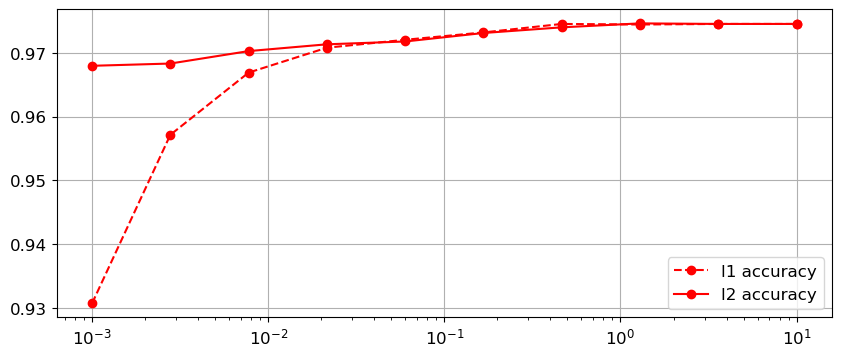

In [15]:
plot_grid_result(result_logreg,param_grid)

In [16]:
grader.check("q5p2")

q5p2 results: All test cases passed!

## 5.3. Package it into a function

Next we will repeat this process with several other classification models. To keep the code clean, we will first collect the steps into a single function. This function receives as inputs:
1. The classifier object, e.g. `LogisticRegression(solver='liblinear',random_state=rng_seed)`
2. The `param_grid` dictionary that defines the search space for `GridSearchCV`.

It should:
1. Create the pipeline model.
2. Construct the `GridSearchCV` object as was done in part 5.2
3. Run `fit` on the grid search object, using the training data (no need to pass the data as an argument to `build_grid_plot`; it's a global variable)
4. Run `unpack_gridsearch` to obtain `result`, `best_params`, `best_model`, and `best_score`.
5. Plot the result with `plot_grid_result` (imported from `lab6_utils`)
6. `return result, best_params, best_model, best_score`


**Note**: This part has no autograder test. Any errors in the `build_grid_plot` function should be caught by tests in subsequent parts. 

In [17]:
def build_grid_plot(pipeline_model,param_grid):
    
    # 1. Create the pipeline model
    model = Pipeline([
    ('scaler' , StandardScaler() ) ,
    ('model' , pipeline_model )
    ])
    
    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    cvfolds=3
    gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cvfolds, scoring=['accuracy'], refit='accuracy')

    # 3. ...
    gs = gs.fit(Xtrain, ytrain)
    
    # 4. Run `unpack_gridsearch` to obtain `result`, `best_params`, `best_model`, and `best_score`.
    result, best_params, best_model, best_score = unpack_gridsearch(gs, param_grid, cvfolds)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result, param_grid)

    # 6. `return result, best_params, best_model, best_score`
    return result, best_params, best_model, best_score

# 6. Random forest

Use the following parameters for the hyper-parameter search:
+ `max_features: ['sqrt','log2']`
+ `n_estimators: np.linspace(2, 100, 5, dtype=int)`


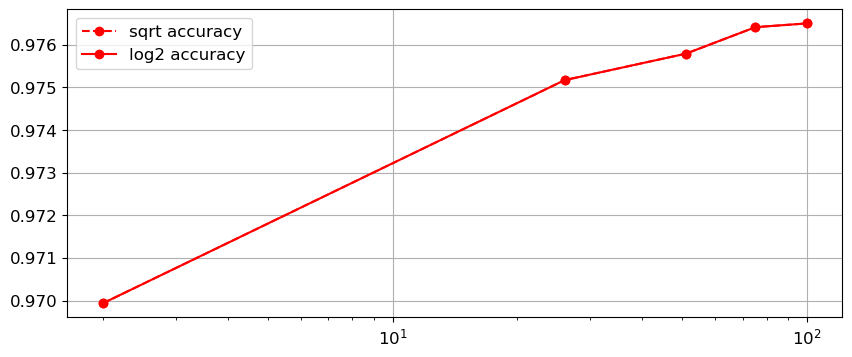

In [18]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'model__max_features' : ['sqrt','log2'],
    'model__n_estimators' : np.linspace(2, 100, 5, dtype=int) }

model = RandomForestClassifier(random_state=rng_seed)

result_rf, best_params_rf, best_model_rf, best_score_rf = build_grid_plot(model, param_grid_rf)

In [19]:
grader.check("q6")

q6 results: All test cases passed!

# 7. AdaBoost

Use the following parameters for the hyper-parameter search:
+ `learning_rate: [0.01,0.1]`
+ `n_estimators: np.linspace(20, 100, 5, dtype=int)`

**Note**: 

+ Remember to set the random state for the model in the model's constructor.
+ We pass `algorithm='SAMME'` into the `AdaBoostClassifier` constructor in order to avoid a very annoying warning message that gets printed if we don't do that. 

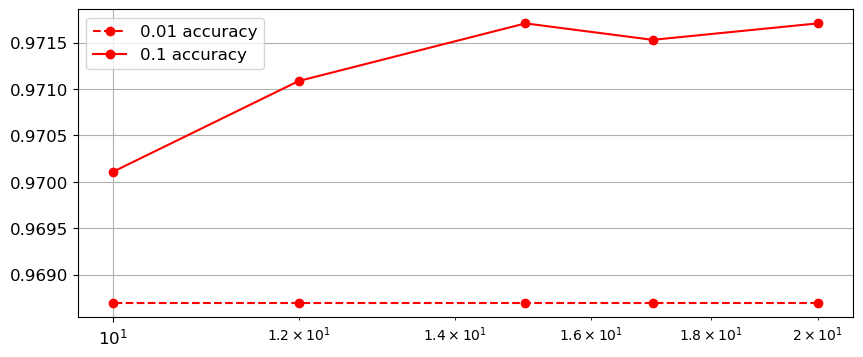

In [20]:
from sklearn.ensemble import AdaBoostClassifier

param_grid_ab = {
    'model__learning_rate' : [0.01,0.1],
    'model__n_estimators' : np.linspace(20, 10, 5, dtype=int) }

model = AdaBoostClassifier(algorithm='SAMME',random_state=rng_seed)

result_ab, best_params_ab, best_model_ab, best_score_ab = build_grid_plot(model, param_grid_ab)

In [21]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Gradient Boosted Trees

Use the following parameters for the hyper-parameter search:
+ `learning_rate: [0.1,1.0]`
+ `n_estimators: [50,75,100]`

**Note**: Remember to set the random state for the model in the model's constructor.

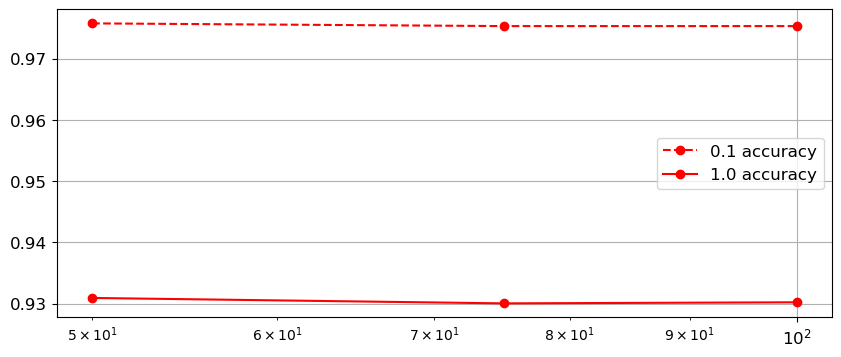

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbc = {
    'model__learning_rate' : [0.1, 1.0],
    'model__n_estimators' : [50, 75, 100] }

model = GradientBoostingClassifier(random_state=rng_seed)

result_gbc, best_params_gbc, best_model_gbc, best_score_gbc = build_grid_plot(model, param_grid_gbc)

In [23]:
grader.check("q8")

q8 results: All test cases passed!

# 9. Final model selection

We have now build 4 separate classifiers: logistic regression, random forest, AdaBoost, and Gradient boosted trees. These are stored below in the `all_models` list. Select from this ist the classifier with the best score. Save the corresponding name, model, and score to variables `best_name`, `best_model`, and `best_score` respoenctively. 

Then compute the test accuracy for the selected model, using its `predict` and `accuracy_score` functions. Store the result as `test_accuracy`.

In [25]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

all_models = [
    ('logreg',best_model_logreg, best_score_logreg),
    ('rf',best_model_rf, best_score_rf),
    ('ab',best_model_ab, best_score_ab),
    ('gbc',best_model_gbc, best_score_gbc),
]

best_name = None
best_model = None
best_score = -1

for name, model, score in all_models:
    if score > best_score:
        best_name = name
        best_model = model
        best_score = score
        
ypred = best_model.predict(Xtest)
test_accuracy = accuracy_score(ytest, ypred)

In [26]:
grader.check("q9")

q9 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [27]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)